<a href="https://colab.research.google.com/github/RinadAkel/NER-Graduation-Project/blob/main/NerProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#The needed libraries: (more libraries will be added when needed)
import pandas as pd
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Dropout
from keras.models import Model, Input
import tensorflow as tf
#from keras.models import Model
#from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint
from sklearn.metrics import f1_score, recall_score, precision_score
from keras.utils.vis_utils import plot_model
from tensorflow.keras import backend as K

In [ ]:
#Clone the repo containing the dataset:
!git clone https://github.com/RinadAkel/NerProject
%cd NerProject

Cloning into 'NerProject'...
remote: Enumerating objects: 3, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3 (delta 0), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (3/3), done.
/content/NerProject


In [ ]:
#Read the csv file:
df = pd.read_csv('ner_dataset.csv',encoding= 'unicode_escape')

In [ ]:
#Display first 10 rows:
df.head(10)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,NaN,of,IN,O
2,NaN,demonstrators,NNS,O
3,NaN,have,VBP,O
4,NaN,marched,VBN,O
5,NaN,through,IN,O
6,NaN,London,NNP,B-geo
7,NaN,to,TO,O
8,NaN,protest,VB,O
9,NaN,the,DT,O


In [ ]:
print(df.shape)

(1048575, 4)


In [ ]:
# Check the count of categorical features:
df.describe(include='O')

,Sentence #,Word,POS,Tag
count,47959,1048575,1048575,1048575
unique,47959,35178,42,17
top,Sentence: 1,the,NN,O
freq,1,52573,145807,887908


In [ ]:
#Display the unique Tags:
print("Here are the list of the unique tags: ")
df['Tag'].unique()

Here are the list of the unique tags: 


array(['O', 'B-geo', 'B-gpe', 'B-per', 'I-geo', 'B-org', 'I-org', 'B-tim',
       'B-art', 'I-art', 'I-per', 'I-gpe', 'I-tim', 'B-nat', 'B-eve',
       'I-eve', 'I-nat'], dtype=object)

In [ ]:
#Check for null values:
#As we can see there are no missing value for each of the word, pos and tag
#The missing values are just for the sentence nb
#The missing values are represented by NaN
df.isnull().sum()

Sentence #    1000616
Word                0
POS                 0
Tag                 0
dtype: int64

**Note: If we take a look on the dataset we can notice that the first word in the sentence have a value in the column representing the Sentence Number however the rest of the words in the same sentence have NaN.**

**To Solve this problem we are going to give Sentence Number for each word in this sentence so that we no longer have NaNs.**

In [ ]:
#fill the df:
df = df.fillna(method = 'ffill') #ffill: fills the missing value the same as the values before it

In [ ]:
#Display from row 20 to 30 in order to see how it is filled:
print(df.iloc[20:30])

     Sentence #      Word  POS Tag
20  Sentence: 1      from   IN   O
21  Sentence: 1      that   DT   O
22  Sentence: 1   country   NN   O
23  Sentence: 1         .    .   O
24  Sentence: 2  Families  NNS   O
25  Sentence: 2        of   IN   O
26  Sentence: 2  soldiers  NNS   O
27  Sentence: 2    killed  VBN   O
28  Sentence: 2        in   IN   O
29  Sentence: 2       the   DT   O


In [ ]:
#Check how many times is each tag found:
print(df['Tag'].value_counts())

O        887908
B-geo     37644
B-tim     20333
B-org     20143
I-per     17251
B-per     16990
I-org     16784
B-gpe     15870
I-geo      7414
I-tim      6528
B-art       402
B-eve       308
I-art       297
I-eve       253
B-nat       201
I-gpe       198
I-nat        51
Name: Tag, dtype: int64


In [ ]:
#Plot the count of each tag:
#The library is imported in the first cell.
count = df['Tag'].value_counts()
fig = px.bar(count, title="The Tags Values",height=400)
fig.show()

In [ ]:
#Retrieve Words with their POS and tag as tuples.
class sentence(object): #the object here is the df
    def __init__(self, df):
        self.n_sent = 1 #nb of the sentence
        self.df = df #dataset used
        self.empty = False  #not empty
        agg = lambda s : [(w, p, t) for w, p, t in zip(s['Word'].values.tolist(),
                                                       s['POS'].values.tolist(),
                                                       s['Tag'].values.tolist())]  #looping over the dataset
        self.grouped = self.df.groupby("Sentence #").apply(agg) #group the sentence based on the sentence number 
        self.sentences = [s for s in self.grouped]
        
    def get_text(self): #to get the full sentence and move on to the next one by adding 1 t the n_sent
        try:
            s = self.grouped['Sentence: {}'.format(self.n_sent)]
            self.n_sent +=1
            return s
        except:
            return None

In [ ]:
#Apply the class:
getter = sentence(df)

In [ ]:
#Print the words , POS and Tags as tuples:
sent = getter.get_text()
print(sent)

[('Thousands', 'NNS', 'O'), ('of', 'IN', 'O'), ('demonstrators', 'NNS', 'O'), ('have', 'VBP', 'O'), ('marched', 'VBN', 'O'), ('through', 'IN', 'O'), ('London', 'NNP', 'B-geo'), ('to', 'TO', 'O'), ('protest', 'VB', 'O'), ('the', 'DT', 'O'), ('war', 'NN', 'O'), ('in', 'IN', 'O'), ('Iraq', 'NNP', 'B-geo'), ('and', 'CC', 'O'), ('demand', 'VB', 'O'), ('the', 'DT', 'O'), ('withdrawal', 'NN', 'O'), ('of', 'IN', 'O'), ('British', 'JJ', 'B-gpe'), ('troops', 'NNS', 'O'), ('from', 'IN', 'O'), ('that', 'DT', 'O'), ('country', 'NN', 'O'), ('.', '.', 'O')]


In [ ]:
#Display the first sentence as array:
sentences = [[word[0] for word in sentence] for sentence in getter.sentences]
sentences[0]

['Thousands',
 'of',
 'demonstrators',
 'have',
 'marched',
 'through',
 'London',
 'to',
 'protest',
 'the',
 'war',
 'in',
 'Iraq',
 'and',
 'demand',
 'the',
 'withdrawal',
 'of',
 'British',
 'troops',
 'from',
 'that',
 'country',
 '.']

In [ ]:
#Display the First sentence fully:
sentences = [" ".join([s[0] for s in sent]) for sent in getter.sentences]
sentences[100]

'She was a longtime member of the Zapatista movement and appeared in public wearing a black ski mask .'

**This next step is an important step in preparation for text preprocessing:**

(array([3.1390e+03, 1.5680e+04, 1.9769e+04, 8.0290e+03, 1.1500e+03,
        1.6500e+02, 2.2000e+01, 2.0000e+00, 2.0000e+00, 1.0000e+00]),
 array([  3. ,  56.8, 110.6, 164.4, 218.2, 272. , 325.8, 379.6, 433.4,
        487.2, 541. ]),
 <a list of 10 Patch objects>)

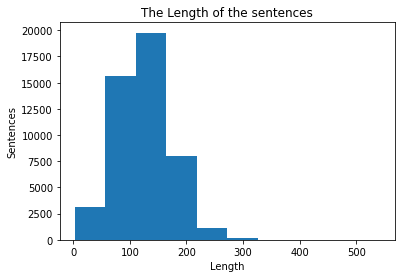

In [ ]:
#Getting the sentences length and plotting it:
len_sent=[len(sent) for sent in sentences]
plt.title("The Length of the sentences")
plt.xlabel("Length")
plt.ylabel("Sentences")
plt.hist(len_sent)

In [ ]:
sentences = getter.sentences

In [ ]:
#Getting unique words and labels from data:
unique_words = list(df['Word'].unique())
tags = list(df['Tag'].unique())
print(unique_words)
print(tags)

['Thousands', 'of', 'demonstrators', 'have', 'marched', 'through', 'London', 'to', 'protest', 'the', 'war', 'in', 'Iraq', 'and', 'demand', 'withdrawal', 'British', 'troops', 'from', 'that', 'country', '.', 'Families', 'soldiers', 'killed', 'conflict', 'joined', 'protesters', 'who', 'carried', 'banners', 'with', 'such', 'slogans', 'as', '"', 'Bush', 'Number', 'One', 'Terrorist', 'Stop', 'Bombings', 'They', 'Houses', 'Parliament', 'a', 'rally', 'Hyde', 'Park', 'Police', 'put', 'number', 'marchers', 'at', '10,000', 'while', 'organizers', 'claimed', 'it', 'was', '1,00,000', 'The', 'comes', 'on', 'eve', 'annual', 'conference', 'Britain', "'s", 'ruling', 'Labor', 'Party', 'southern', 'English', 'seaside', 'resort', 'Brighton', 'party', 'is', 'divided', 'over', 'participation', 'continued', 'deployment', '8,500', 'march', 'came', 'ahead', 'anti-war', 'protests', 'today', 'other', 'cities', ',', 'including', 'Rome', 'Paris', 'Madrid', 'International', 'Atomic', 'Energy', 'Agency', 'hold', 'sec

In [ ]:
#Preparing to do dictionaries:
# Dictionary word:index pair
# word is key and its value is corresponding index
word_to_index = {w : i + 2 for i, w in enumerate(unique_words)} #enumerate is used to loop the array and give index to each of the words
#Why did we write i+2? the first two indices 0 and 1 are booked for NEW and PAD 
word_to_index["UNK"] = 1 #The unknown words which are basically new words are given an index of 1 
word_to_index["PAD"] = 0 #For Padding

In [ ]:
word_to_index

{'Thousands': 2,
 'of': 3,
 'demonstrators': 4,
 'have': 5,
 'marched': 6,
 'through': 7,
 'London': 8,
 'to': 9,
 'protest': 10,
 'the': 11,
 'war': 12,
 'in': 13,
 'Iraq': 14,
 'and': 15,
 'demand': 16,
 'withdrawal': 17,
 'British': 18,
 'troops': 19,
 'from': 20,
 'that': 21,
 'country': 22,
 '.': 23,
 'Families': 24,
 'soldiers': 25,
 'killed': 26,
 'conflict': 27,
 'joined': 28,
 'protesters': 29,
 'who': 30,
 'carried': 31,
 'banners': 32,
 'with': 33,
 'such': 34,
 'slogans': 35,
 'as': 36,
 '"': 37,
 'Bush': 38,
 'Number': 39,
 'One': 40,
 'Terrorist': 41,
 'Stop': 42,
 'Bombings': 43,
 'They': 44,
 'Houses': 45,
 'Parliament': 46,
 'a': 47,
 'rally': 48,
 'Hyde': 49,
 'Park': 50,
 'Police': 51,
 'put': 52,
 'number': 53,
 'marchers': 54,
 'at': 55,
 '10,000': 56,
 'while': 57,
 'organizers': 58,
 'claimed': 59,
 'it': 60,
 'was': 61,
 '1,00,000': 62,
 'The': 63,
 'comes': 64,
 'on': 65,
 'eve': 66,
 'annual': 67,
 'conference': 68,
 'Britain': 69,
 "'s": 70,
 'ruling': 71,
 '

In [ ]:
tag_to_index = {t : i + 1 for i, t in enumerate(tags)}
tag_to_index["PAD"] = 0  # assign PAD word to tag index 0

In [ ]:
idx2word = {i: w for w, i in word_to_index.items()} # dict having idex as key and word as value, so its idex to word dict

In [ ]:
idx2tag = {i: w for w, i in tag_to_index.items()}# dict having atg as key and idex as value,  so its idex to tag

In [ ]:
#trying the dict
print("The word Beirust has index: {}".format(word_to_index["Beirut"]))

The word Beirust has index: 2429


In [ ]:
#Converting each word into list of index from list of words
X = [[word_to_index[w[0]] for w in s] for s in sentences]
print(X[0])

[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 11, 17, 3, 18, 19, 20, 21, 22, 23]


In [ ]:
#Padding each sequence to have same length  of 150 so maximum is 150
maxlen = 150
X = pad_sequences(maxlen = maxlen, sequences = X, padding = "post", value = word_to_index["PAD"])
print(X[0])

[ 2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 11 17  3 18 19 20 21 22 23
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0]


In [ ]:
#Converting tags to index:
y = [[tag_to_index[w[2]] for w in s] for s in sentences]
print(y[0])

[1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1]


In [ ]:
#Padding tag:
y = pad_sequences(maxlen = maxlen, sequences = y, padding = "post", value = tag_to_index["PAD"])
print(y[0])

[1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 1 1 1 3 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]


In [ ]:
#Getting the number of unique tags:
ntags = df['Tag'].nunique()
print("The number of unique tags is",ntags,".")

The number of unique tags is 17 .


In [ ]:
#Performing One-hot Encoding:
y = [to_categorical(i, num_classes = ntags + 1) for i in y] # +1 for PAD 
print("One hot encodding labels")
print(y[0])

One hot encodding labels
[[0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]]


In [ ]:
#Splitting dataframe into 20% for testing and 80% for training
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42) 

In [ ]:
#Getting the sizes: 
print("Size of training input : ", X_train.shape)
print("Size of training output: ", np.array(y_train).shape)
print("Size of testing input: ", X_test.shape)
print("Size of testing output: ", np.array(y_test).shape)

Size of training input :  (38367, 150)
Size of training output:  (38367, 150, 18)
Size of testing input:  (9592, 150)
Size of testing output:  (9592, 150, 18)


**Start Building the Model** <br>

**Batch Size** amount of data you feed to the network before performing an update in the weights. <br>
**epochs** The number of times we feed ALL the training set examples to our
network.

In [ ]:
# Number of data points passed in each iteration
batch_size = 128
# Dimension of embedding vector
embedding = 100 

In [ ]:
#Building the model
def build_model( maxlen, emb_dim,vocab_size, n_tags):
  # maxlen(150) dimensional word indices as input
  input = Input(shape=(maxlen,))
  
  # Embedding layer of same length output (50 dim embedding will be generated)
  model = Embedding(input_dim=vocab_size, output_dim=emb_dim, input_length=maxlen)(input)
  
  # Bidirectional LSTM to learn from both forward as well as backward context
  model = Bidirectional(LSTM(units=50, return_sequences=True, recurrent_dropout=0.1))(model)
  model=TimeDistributed(Dense(50, activation="relu"))(model)

  # Adding a TimeDistributedDense, to applying a Dense layer on each 180 timesteps
  out = TimeDistributed(Dense(n_tags, activation="softmax"))(model) # softmax output layer
  model = Model(input, out)
  
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])

  return model

num_tags = df['Tag'].nunique() +1 

model=build_model(maxlen, embedding,len(unique_words)+2,num_tags)
#model=build_model(150,100,len(words)+2,18)

In [ ]:

#num_tags = df['Tag'].nunique() +1 

# Model architecture
#input = Input(shape = (max_len,))
#emb1 = Embedding(input_dim = len(words) + 2, output_dim = embedding, input_length = max_len, mask_zero = True)(input)
#lstm =Bidirectional(LSTM(units = 50, return_sequences=True, recurrent_dropout=0.1))(emb1)
#td=TimeDistributed(Dense(50, activation="relu"))(lstm)

#outputs = Dense(num_tags, activation="softmax")(td)
#model = Model(inputs=input , outputs=outputs)

# compile
#model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) #tf.keras.metrics.Precision(), tf.keras.metrics.Recall()
# summarize
#print(model.summary())

In [ ]:
checkpointer = ModelCheckpoint(filepath = 'model.h5',
                       verbose = 0,
                       mode = 'auto',
                       save_best_only = True,
                       monitor='val_loss')

In [ ]:
history = model.fit(X_train, np.array(y_train), batch_size=batch_size, epochs=8,
                    validation_split=0.1, callbacks=[checkpointer])

Epoch 1/8
270/270 [==============================] - 201s 745ms/step - loss: 0.0871 - accuracy: 0.9790 - precision: 0.9856 - recall: 0.9769 - val_loss: 0.0554 - val_accuracy: 0.9831 - val_precision: 0.9965 - val_recall: 0.9772
Epoch 2/8
270/270 [==============================] - 200s 740ms/step - loss: 0.0410 - accuracy: 0.9886 - precision: 0.9971 - recall: 0.9817 - val_loss: 0.0320 - val_accuracy: 0.9913 - val_precision: 0.9963 - val_recall: 0.9863
Epoch 3/8
270/270 [==============================] - 200s 741ms/step - loss: 0.0230 - accuracy: 0.9936 - precision: 0.9966 - recall: 0.9905 - val_loss: 0.0234 - val_accuracy: 0.9934 - val_precision: 0.9956 - val_recall: 0.9918
Epoch 4/8
270/270 [==============================] - 199s 736ms/step - loss: 0.0167 - accuracy: 0.9953 - precision: 0.9967 - recall: 0.9939 - val_loss: 0.0221 - val_accuracy: 0.9939 - val_precision: 0.9952 - val_recall: 0.9931
Epoch 5/8
270/270 [==============================] - 200s 742ms/step - loss: 0.0135 - accura

In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'precision', 'recall', 'val_loss', 'val_accuracy', 'val_precision', 'val_recall'])

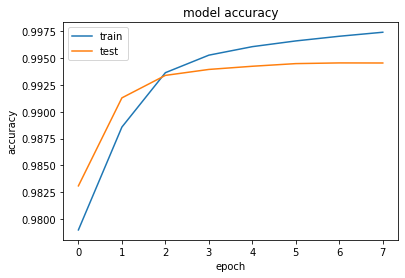

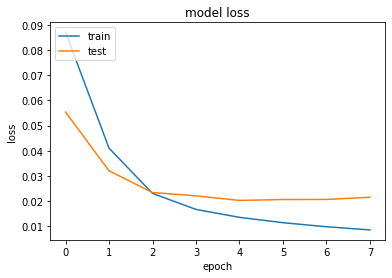

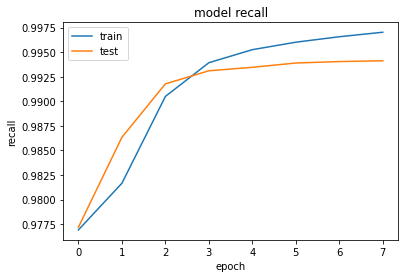

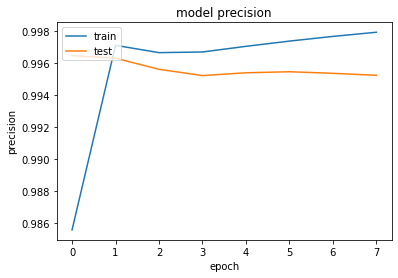

In [ ]:
# summarize history for training and validation accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for training and validation recall
plt.plot(history.history['recall'])
plt.plot(history.history['val_recall'])
plt.title('model recall')
plt.ylabel('recall')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for training and validation precision
plt.plot(history.history['precision'])
plt.plot(history.history['val_precision'])
plt.title('model precision')
plt.ylabel('precision')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

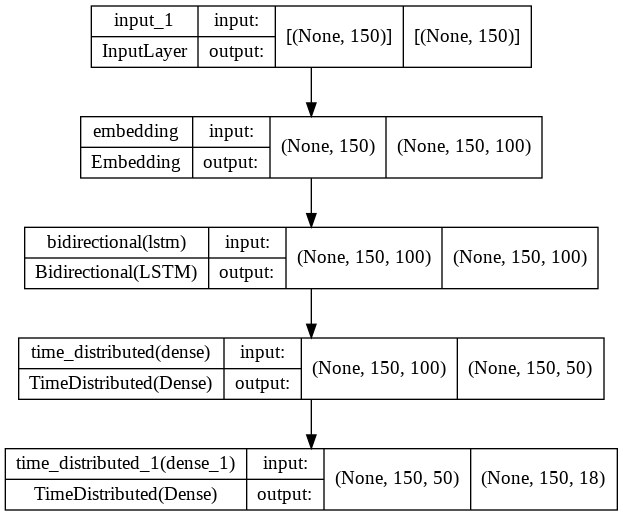

In [ ]:
plot_model(model, show_shapes=True, to_file='model.png')

In [ ]:
#Checking
print(idx2tag[0])
print(idx2tag[1])

PAD
O


In [ ]:
#making the predictions
predictions=model.predict(X_test)

In [ ]:
def metrics_computation(y_true, y_pred):    
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        
        recall = TP / (Positives+K.epsilon())    
        return recall 
     
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    
        precision = TP / (Pred_Positives+K.epsilon())
        return precision 
    
    precision= precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)

    f1=2*((precision*recall)/(precision+recall+K.epsilon()))
    
    return f1, precision, recall

In [ ]:
f1, precision, recall = metrics_computation(predictions,y_test )
print("Recall: ", recall.numpy())
print("Precision: ", precision.numpy())
print("f1-score: ", f1.numpy())

Recall:  0.99528825
Precision:  0.9942174
f1-score:  0.99475247


In [ ]:
#https://machinelearningmastery.com/precision-recall-and-f-measure-for-imbalanced-classification/
#(1+beta^2)/((beta^2)/recall + 1/precision)
beta=2
f2= (1+beta^2)/((beta^2)/recall.numpy() + 1/precision.numpy())
print("f2-score: ",f2)

f2-score:  0.9942173957824707


In [ ]:
# At every execution model picks some random test sample from test set.
i = np.random.randint(0,X_test.shape[0]) # choose a random number between 0 and len(X_te)b
p = model.predict(np.array([X_test[i]]))
p = np.argmax(p, axis=-1)
true = np.argmax(y_test[i], -1)

print("Sample number {} of {} (Test Set)".format(i, X_test.shape[0]))
# Visualization
print("{:15}||{:5}||{}".format("Word", "True", "Pred"))
print(30 * "=")
for w, t, pred in zip(X_test[i], true, p[0]):
    if w != 0:
        print("{:15}: {:5} {}".format(unique_words[w-2], idx2tag[t], idx2tag[pred]))

Sample number 9453 of 9592 (Test Set)
Word           ||True ||Pred
Donor          : O     O
countries      : O     O
have           : O     O
pledged        : O     O
almost         : O     O
$              : O     O
5              : O     O
billion        : O     O
in             : O     O
aid            : O     O
so             : O     O
far            : O     O
,              : O     O
with           : O     O
the            : O     O
United         : B-geo B-geo
States         : I-geo I-geo
promising      : O     O
$              : O     O
1.1            : O     O
billion        : O     O
for            : O     O
the            : O     O
war-torn       : O     O
country        : O     O
.              : O     O


In [ ]:
!pip install -q tensorflow-model-optimization 

     |████████████████████████████████| 237 kB 28 kB/s 


In [ ]:
import tensorflow_model_optimization as tfmot

model_for_export = tfmot.sparsity.keras.strip_pruning(model)
model_for_export.summary()

keras_file = 'stripped_model_8epochs.h5'
tf.keras.models.save_model(model_for_export, keras_file, include_optimizer=False)
print('Saved Keras model to:', keras_file)


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150)]             0         
                                                                 
 embedding (Embedding)       (None, 150, 100)          3518000   
                                                                 
 bidirectional (Bidirectiona  (None, 150, 100)         60400     
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 150, 50)          5050      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 150, 18)          918       
 tributed)                                                       
                                                             